# Meta-Learners 

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, log_loss
import seaborn as sns

In [2]:
def standardise_df(df, prefix):
    df = df.copy()
    # label column
    if "label" in df.columns and "true_label" not in df.columns:
        df = df.rename(columns={"label": "true_label"})
    # add id if missing
    if "id" not in df.columns:
        df.insert(0, "id", np.arange(len(df)))
    # rename class probability columns
    prob_cols = []
    for i in range(10):
        matches = [c for c in df.columns if prefix in c and f"class_{i}" in c]
        if not matches:
            raise ValueError(f"No column found for {prefix}_class_{i}")
        old = matches[0]
        new = f"{prefix}_class_{i}"
        df = df.rename(columns={old: new})
        prob_cols.append(new)
    # Check probability sums - prob should be up to a sum of 1
    prob_sum = df[prob_cols].sum(axis=1)
    if not np.allclose(prob_sum, 1.0, atol=1e-3):
        print(f"{prefix} probabilities do NOT sum to 1 for all samples. RECHECK")
        print(f" Mean sum = {prob_sum.mean():.4f}, Std = {prob_sum.std():.4f}")
        # normalise in case probs don't sum to 1
        df[prob_cols] = df[prob_cols].div(prob_sum, axis=0)
    return df

# calculate entropy 
def compute_entropy(probs):
    return -np.sum(probs * np.log(probs + 1e-12), axis=1)

# load the predictions for both cnn and blr 
def load_level(level, split="test"):
    # load the cnn files 
    if split == "train":
        cnn_file = f"cnn_dropout_train_predictions_degradation_{level}.csv"
    elif split == "test":
        cnn_file = f"cnn_dropout_test_predictions_degradation_{level}.csv"
    else:
        raise ValueError("split must be 'train' or 'test'")

    cnn = pd.read_csv(cnn_file)

    # load the blr files for both train and test sets
    if split == "train":
        blr = pd.read_csv(f"blr_train_predictions_deg{level}.csv")
    else:
        blr = pd.read_csv(f"blr_predictions_deg_{level}.csv")

    # check sizes if they are matching 
    if len(cnn) != len(blr):
        raise ValueError(
            f"There is a row mismatch for level={level}, split={split} - RECHECK:\n"
            f"CNN rows = {len(cnn)}\n"
            f"BLR rows = {len(blr)}\n"
            f"These have to match!")

    # get the true labels 
    if "true_label" in cnn.columns:
        y = cnn["true_label"].values
    elif "label" in cnn.columns:
        y = cnn["label"].values
    else:
        raise ValueError("No label column found in CNN file-RECHECK")

    # extract the probabilities for cnn and blr (and standard dev for the blr)
    cnn_probs = cnn[[c for c in cnn.columns if "cnn" in c and "class_" in c]].values
    blr_probs = blr[[c for c in blr.columns if "blr" in c and "class_" in c and "_std" not in c]].values
    blr_stds  = blr[[c for c in blr.columns if "_std" in c]].values

    # collect the entropies
    cnn_entropy = compute_entropy(cnn_probs)
    blr_entropy = compute_entropy(blr_probs)

    # poduces combined meta-features
    X = np.hstack([
        cnn_probs,
        blr_probs,
        blr_stds,
        cnn_entropy.reshape(-1, 1),
        blr_entropy.reshape(-1, 1)])

    # for easier debugging 
    print(f"\n Loaded level {level} ({split})")
    print("CNN rows:", len(cnn))
    print("BLR rows:", len(blr))

    return X, y


# calculate AIC for each model 
def compute_aic(log_loss_value, n_params, n_samples):
    aic = 2 * n_params + 2 * n_samples * log_loss_value
    return aic

def mlp_params(mlp):
    # counts teh number of parameters of the MLP (weights and biases)
    params = sum(w.size + b.size for w, b in zip(mlp.coefs_, mlp.intercepts_))
    return params

In [3]:
# Degradation levels
levels = [0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100]

# define the meta learners
meta_models = {
    "LogReg": LogisticRegression(max_iter=500, multi_class="multinomial", C=0.5),
    #"RF": RandomForestClassifier(n_estimators=200, random_state=0),
    "GBM": GradientBoostingClassifier(n_estimators=200, learning_rate=0.05, max_depth=3, random_state=0),
    "MLP": MLPClassifier(hidden_layer_sizes=(64, 32), activation="tanh",
                         solver="adam", alpha=1e-4, learning_rate_init=1e-3,
                         max_iter=200, random_state=0)}

In [4]:
# calculate the total trainable parameters count 
def count_parameters(model):
    
    # Logistic Regression (linear)
    if hasattr(model, "coef_"):
        return model.coef_.size + model.intercept_.size
    
    # MLP neural network
    if hasattr(model, "coefs_") and hasattr(model, "intercepts_"):
        return sum(w.size + b.size for w, b in zip(model.coefs_, model.intercepts_))
    
    # Tree-based models - this is an approximation as the exact calc is not possible 
    if hasattr(model, "feature_importances_"):
        return len(model.feature_importances_)
    
    # for debugging purposes 
    return 1


In [5]:
from sklearn.base import clone

# save the results 
results = []
aic_summary = {}
trained_models = {}

for level in levels:
    # load features and labels
    X_train, y_train = load_level(level, split="train")
    X_test, y_test   = load_level(level, split="test")

    # calculate the number of samples, classes and parameters
    n_samples = len(y_test)        
    n_classes = len(np.unique(y_train))  
    n_features = X_train.shape[1]    

    for name, base_model in meta_models.items():
        # clone model to avoid destroying it 
        model = clone(base_model) 
        model.fit(X_train, y_train)
        trained_models[(level, name)] = model
        # predict probabilities
        probs = model.predict_proba(X_test)
        # calculate the accuracy and NLL
        acc = accuracy_score(y_test, probs.argmax(axis=1)) * 100
        nll = log_loss(y_test, probs, labels=np.arange(probs.shape[1]))
        # calculate the AIC 
        n_params = count_parameters(model)
        aic = compute_aic(nll, n_params, n_samples)
        # save results
        results.append({
            "Degradation": level,
            "Model": name,
            "Accuracy": acc,
            "AIC": aic,
            "NLL": nll})
        aic_summary.setdefault(name, []).append(aic)


 Loaded level 0 (train)
CNN rows: 54000
BLR rows: 54000

 Loaded level 0 (test)
CNN rows: 10000
BLR rows: 10000


/Users/ioannaioannidou/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/ioannaioannidou/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(



 Loaded level 5 (train)
CNN rows: 54000
BLR rows: 54000

 Loaded level 5 (test)
CNN rows: 10000
BLR rows: 10000


/Users/ioannaioannidou/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/ioannaioannidou/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(



 Loaded level 10 (train)
CNN rows: 54000
BLR rows: 54000

 Loaded level 10 (test)
CNN rows: 10000
BLR rows: 10000


/Users/ioannaioannidou/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/ioannaioannidou/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(



 Loaded level 15 (train)
CNN rows: 54000
BLR rows: 54000

 Loaded level 15 (test)
CNN rows: 10000
BLR rows: 10000


/Users/ioannaioannidou/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/ioannaioannidou/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(



 Loaded level 20 (train)
CNN rows: 54000
BLR rows: 54000

 Loaded level 20 (test)
CNN rows: 10000
BLR rows: 10000


/Users/ioannaioannidou/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/ioannaioannidou/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(



 Loaded level 25 (train)
CNN rows: 54000
BLR rows: 54000

 Loaded level 25 (test)
CNN rows: 10000
BLR rows: 10000


/Users/ioannaioannidou/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/ioannaioannidou/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(



 Loaded level 30 (train)
CNN rows: 54000
BLR rows: 54000

 Loaded level 30 (test)
CNN rows: 10000
BLR rows: 10000


/Users/ioannaioannidou/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/ioannaioannidou/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(



 Loaded level 35 (train)
CNN rows: 54000
BLR rows: 54000

 Loaded level 35 (test)
CNN rows: 10000
BLR rows: 10000


/Users/ioannaioannidou/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/ioannaioannidou/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(



 Loaded level 40 (train)
CNN rows: 54000
BLR rows: 54000

 Loaded level 40 (test)
CNN rows: 10000
BLR rows: 10000


/Users/ioannaioannidou/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/ioannaioannidou/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(



 Loaded level 45 (train)
CNN rows: 54000
BLR rows: 54000

 Loaded level 45 (test)
CNN rows: 10000
BLR rows: 10000


/Users/ioannaioannidou/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/ioannaioannidou/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(



 Loaded level 50 (train)
CNN rows: 54000
BLR rows: 54000

 Loaded level 50 (test)
CNN rows: 10000
BLR rows: 10000


/Users/ioannaioannidou/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/ioannaioannidou/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(



 Loaded level 55 (train)
CNN rows: 54000
BLR rows: 54000

 Loaded level 55 (test)
CNN rows: 10000
BLR rows: 10000


/Users/ioannaioannidou/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/ioannaioannidou/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(



 Loaded level 60 (train)
CNN rows: 54000
BLR rows: 54000

 Loaded level 60 (test)
CNN rows: 10000
BLR rows: 10000


/Users/ioannaioannidou/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/ioannaioannidou/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(



 Loaded level 65 (train)
CNN rows: 54000
BLR rows: 54000

 Loaded level 65 (test)
CNN rows: 10000
BLR rows: 10000


/Users/ioannaioannidou/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



 Loaded level 70 (train)
CNN rows: 54000
BLR rows: 54000

 Loaded level 70 (test)
CNN rows: 10000
BLR rows: 10000


/Users/ioannaioannidou/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/ioannaioannidou/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(



 Loaded level 75 (train)
CNN rows: 54000
BLR rows: 54000

 Loaded level 75 (test)
CNN rows: 10000
BLR rows: 10000


/Users/ioannaioannidou/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/ioannaioannidou/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(



 Loaded level 80 (train)
CNN rows: 54000
BLR rows: 54000

 Loaded level 80 (test)
CNN rows: 10000
BLR rows: 10000


/Users/ioannaioannidou/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/ioannaioannidou/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(



 Loaded level 85 (train)
CNN rows: 54000
BLR rows: 54000

 Loaded level 85 (test)
CNN rows: 10000
BLR rows: 10000


/Users/ioannaioannidou/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/ioannaioannidou/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(



 Loaded level 90 (train)
CNN rows: 54000
BLR rows: 54000

 Loaded level 90 (test)
CNN rows: 10000
BLR rows: 10000


/Users/ioannaioannidou/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/ioannaioannidou/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(



 Loaded level 95 (train)
CNN rows: 54000
BLR rows: 54000

 Loaded level 95 (test)
CNN rows: 10000
BLR rows: 10000


/Users/ioannaioannidou/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/ioannaioannidou/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(



 Loaded level 100 (train)
CNN rows: 54000
BLR rows: 54000

 Loaded level 100 (test)
CNN rows: 10000
BLR rows: 10000


/Users/ioannaioannidou/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


In [6]:
levels = [0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100]
  
for level in levels:
    cnn_df = pd.read_csv(f"cnn_dropout_test_predictions_degradation_{level}.csv")
    print(cnn_df.head())
    print(cnn_df.shape)

   cnn_dropout_class_0  cnn_dropout_class_1  cnn_dropout_class_2  \
0         7.146539e-01         2.111886e-07         3.909586e-04   
1         3.060456e-07         9.999932e-01         5.498354e-09   
2         2.538865e-02         2.045608e-05         8.038063e-01   
3         2.069442e-02         1.302009e-04         2.946457e-01   
4         4.185195e-04         3.239181e-06         6.477729e-03   

   cnn_dropout_class_3  cnn_dropout_class_4  cnn_dropout_class_5  \
0             0.000563             0.000055         4.774241e-13   
1             0.000005             0.000001         7.602001e-10   
2             0.000038             0.004700         4.073534e-07   
3             0.006954             0.018908         2.543949e-09   
4             0.823755             0.099714         2.389282e-07   

   cnn_dropout_class_6  cnn_dropout_class_7  cnn_dropout_class_8  \
0         2.842312e-01         6.520945e-14         1.051938e-04   
1         7.011063e-08         1.225978e-09   

In [7]:
# get the prediction for cnn and blr for each degradation 
cnn_results, blr_results = [], []

for level in levels:
    # CNN
    cnn_df = pd.read_csv(f"cnn_dropout_test_predictions_degradation_{level}.csv")
    y_true = cnn_df["true_label"].to_numpy()
    cnn_cols = [c for c in cnn_df.columns if "cnn" in c and "class_" in c]
    cnn_probs = cnn_df[cnn_cols].to_numpy()
    # check if probs sum to 1
    cnn_sums = cnn_probs.sum(axis=1)
    if not np.allclose(cnn_sums, 1.0, atol=1e-3):
        print(f"CNN probs at degradation {level}% don't sum to 1 ")
        # normalise to sum to 1
        cnn_probs /= cnn_sums[:, None]  
    else:
        print(f"CNN probs at degradation {level}% sum correctly to 1.")

    cnn_acc = accuracy_score(y_true, cnn_probs.argmax(axis=1)) * 100
    cnn_nll = log_loss(y_true, cnn_probs, labels=np.arange(cnn_probs.shape[1]))
    cnn_aic = compute_aic(cnn_nll, cnn_probs.shape[1]*10, len(y_true))
    cnn_results.append({"Degradation": level, "Model": "CNN", "Accuracy": cnn_acc, "AIC": cnn_aic})

    # BLR
    blr_df = pd.read_csv(f"blr_predictions_deg_{level}.csv")
    y_true = blr_df["label"].to_numpy() if "true_label" not in blr_df.columns else blr_df["true_label"].to_numpy()
    blr_cols = [c for c in blr_df.columns if "blr" in c and "class_" in c]
    blr_probs = blr_df[blr_cols].to_numpy()
    # check if probs sum to 1
    blr_sums = blr_probs.sum(axis=1)
    if not np.allclose(blr_sums, 1.0, atol=1e-3):
        print(f"BLR probs at degradation {level}% don't sum to 1 ")
        blr_probs /= blr_sums[:, None]  
    else:
        print(f"BLR probs at degradation {level}% sum correctly to 1.")
    blr_acc = accuracy_score(y_true, blr_probs.argmax(axis=1)) * 100
    blr_nll = log_loss(y_true, blr_probs, labels=np.arange(blr_probs.shape[1]))
    blr_aic = compute_aic(blr_nll, blr_probs.shape[1]*10, len(y_true))
    blr_results.append({"Degradation": level, "Model": "BLR", "Accuracy": blr_acc, "AIC": blr_aic})

# combine results
results_df = pd.DataFrame(results + cnn_results + blr_results)

CNN probs at degradation 0% sum correctly to 1.
BLR probs at degradation 0% sum correctly to 1.
CNN probs at degradation 5% sum correctly to 1.
BLR probs at degradation 5% sum correctly to 1.
CNN probs at degradation 10% sum correctly to 1.


/Users/ioannaioannidou/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:259: UserWarning: The y_prob values do not sum to one. Make sure to pass probabilities.
  warnings.warn(
/Users/ioannaioannidou/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:259: UserWarning: The y_prob values do not sum to one. Make sure to pass probabilities.
  warnings.warn(
/Users/ioannaioannidou/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:259: UserWarning: The y_prob values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


BLR probs at degradation 10% sum correctly to 1.
CNN probs at degradation 15% sum correctly to 1.
BLR probs at degradation 15% sum correctly to 1.
CNN probs at degradation 20% sum correctly to 1.
BLR probs at degradation 20% sum correctly to 1.
CNN probs at degradation 25% sum correctly to 1.
BLR probs at degradation 25% sum correctly to 1.
CNN probs at degradation 30% sum correctly to 1.


/Users/ioannaioannidou/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:259: UserWarning: The y_prob values do not sum to one. Make sure to pass probabilities.
  warnings.warn(
/Users/ioannaioannidou/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:259: UserWarning: The y_prob values do not sum to one. Make sure to pass probabilities.
  warnings.warn(
/Users/ioannaioannidou/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:259: UserWarning: The y_prob values do not sum to one. Make sure to pass probabilities.
  warnings.warn(
/Users/ioannaioannidou/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:259: UserWarning: The y_prob values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


BLR probs at degradation 30% sum correctly to 1.
CNN probs at degradation 35% sum correctly to 1.
BLR probs at degradation 35% sum correctly to 1.
CNN probs at degradation 40% sum correctly to 1.
BLR probs at degradation 40% sum correctly to 1.
CNN probs at degradation 45% sum correctly to 1.
BLR probs at degradation 45% sum correctly to 1.
CNN probs at degradation 50% sum correctly to 1.
BLR probs at degradation 50% sum correctly to 1.
CNN probs at degradation 55% sum correctly to 1.
BLR probs at degradation 55% sum correctly to 1.


/Users/ioannaioannidou/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:259: UserWarning: The y_prob values do not sum to one. Make sure to pass probabilities.
  warnings.warn(
/Users/ioannaioannidou/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:259: UserWarning: The y_prob values do not sum to one. Make sure to pass probabilities.
  warnings.warn(
/Users/ioannaioannidou/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:259: UserWarning: The y_prob values do not sum to one. Make sure to pass probabilities.
  warnings.warn(
/Users/ioannaioannidou/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:259: UserWarning: The y_prob values do not sum to one. Make sure to pass probabilities.
  warnings.warn(
/Users/ioannaioannidou/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:259: UserWarning: The y_prob values do not sum to one. Make sure to pass probabilities.
  warnings.warn(
/Users/ioa

CNN probs at degradation 60% sum correctly to 1.
BLR probs at degradation 60% sum correctly to 1.
CNN probs at degradation 65% sum correctly to 1.
BLR probs at degradation 65% sum correctly to 1.
CNN probs at degradation 70% sum correctly to 1.
BLR probs at degradation 70% sum correctly to 1.
CNN probs at degradation 75% sum correctly to 1.
BLR probs at degradation 75% sum correctly to 1.
CNN probs at degradation 80% sum correctly to 1.
BLR probs at degradation 80% sum correctly to 1.
CNN probs at degradation 85% sum correctly to 1.


/Users/ioannaioannidou/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:259: UserWarning: The y_prob values do not sum to one. Make sure to pass probabilities.
  warnings.warn(
/Users/ioannaioannidou/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:259: UserWarning: The y_prob values do not sum to one. Make sure to pass probabilities.
  warnings.warn(
/Users/ioannaioannidou/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:259: UserWarning: The y_prob values do not sum to one. Make sure to pass probabilities.
  warnings.warn(
/Users/ioannaioannidou/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:259: UserWarning: The y_prob values do not sum to one. Make sure to pass probabilities.
  warnings.warn(
/Users/ioannaioannidou/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:259: UserWarning: The y_prob values do not sum to one. Make sure to pass probabilities.
  warnings.warn(
/Users/ioa

BLR probs at degradation 85% sum correctly to 1.
CNN probs at degradation 90% sum correctly to 1.
BLR probs at degradation 90% sum correctly to 1.
CNN probs at degradation 95% sum correctly to 1.
BLR probs at degradation 95% sum correctly to 1.
CNN probs at degradation 100% sum correctly to 1.
BLR probs at degradation 100% sum correctly to 1.


/Users/ioannaioannidou/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:259: UserWarning: The y_prob values do not sum to one. Make sure to pass probabilities.
  warnings.warn(
/Users/ioannaioannidou/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:259: UserWarning: The y_prob values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


# Add degraded images below the graph 

Use Sabereh's code

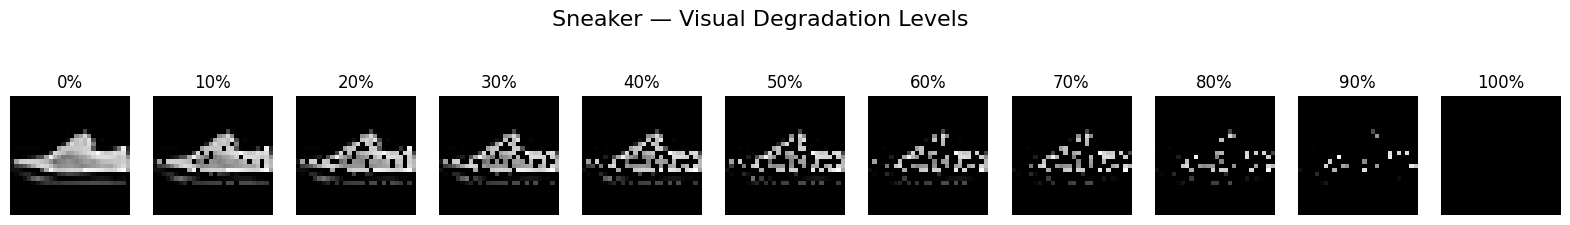

In [8]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

label_map = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot"
}

# A function for one pixel dropout 
def degrade_image(image, dropout_ratio, hidden_value=0):
    img = image.copy().reshape(-1)
    n_pixels = img.size
    n_hide = int(n_pixels * dropout_ratio)

    np.random.seed(42)
    hide_idx = np.random.choice(n_pixels, n_hide, replace=False)
    img[hide_idx] = hidden_value

    return img.reshape(28, 28)


# Load image from dataframe exakctly as above
fashion_train_df = pd.read_csv('/Users/ioannaioannidou/Desktop/Uppsala University/Year 2/Semester 1/Project in DS/data_copy/raw/fashion-mnist-train.csv')
random_row = fashion_train_df.sample(1, random_state=42).iloc[0]

label = random_row.iloc[0]
label_name = label_map[int(label)] # mapping the label numbers to their names
image = random_row.iloc[1:].to_numpy().reshape(28, 28)

dropout_levels = [0,10,20,30,40,50,60,70,80,90,100]

# Single row plot
plt.figure(figsize=(20, 3))
for i, d in enumerate(dropout_levels):
    degraded = degrade_image(image, d/100)
    plt.subplot(1, len(dropout_levels), i+1)
    plt.imshow(degraded, cmap="gray")
    plt.title(f"{d}%")
    plt.axis("off")

plt.suptitle(f"{label_name} — Visual Degradation Levels", fontsize=16)
plt.show()

In [ ]:
cnn_results, blr_results = [], []

label_map = {
    0: "T-shirt/top", 1: "Trouser", 2: "Pullover", 3: "Dress",
    4: "Coat", 5: "Sandal", 6: "Shirt",
    7: "Sneaker", 8: "Bag", 9: "Ankle boot"}

label = int(random_row.iloc[0])
label_name = label_map[label]

# calculate the log loss but ensure numerical stability by 
# clipping the probabilities 
def safe_log_loss(y_true, probs, eps=1e-12):
    probs = np.clip(probs, eps, 1 - eps)
    # re normalise the rows
    probs = probs / probs.sum(axis=1, keepdims=True)
    return log_loss(y_true, probs, labels=np.arange(probs.shape[1]))


for level in levels:
    # for cnn
    cnn_df = pd.read_csv(f"cnn_dropout_test_predictions_degradation_{level}.csv")
    y_true = cnn_df["true_label"].to_numpy()
    cnn_cols = [c for c in cnn_df.columns if "cnn" in c and "class_" in c]
    cnn_probs = cnn_df[cnn_cols].to_numpy()
    # calculate the metrics we are interested in 
    cnn_acc = accuracy_score(y_true, cnn_probs.argmax(axis=1)) * 100
    cnn_nll = safe_log_loss(y_true, cnn_probs)
    cnn_aic = compute_aic(cnn_nll, cnn_probs.shape[1] * 10, len(y_true))
    # save the results in a table
    cnn_results.append({
        "Degradation": level,
        "Model": "CNN",
        "Accuracy": cnn_acc,
        "AIC": cnn_aic,
        "NLL": cnn_nll})

    # for blr
    blr_df = pd.read_csv(f"blr_predictions_deg_{level}.csv")
    y_true = blr_df["true_label"].to_numpy() if "true_label" in blr_df.columns else blr_df["label"].to_numpy()
    blr_cols = [c for c in blr_df.columns if "blr" in c and "class_" in c]
    blr_probs = blr_df[blr_cols].to_numpy()
    # calculate the metrics we are interested in 
    blr_acc = accuracy_score(y_true, blr_probs.argmax(axis=1)) * 100
    blr_nll = safe_log_loss(y_true, blr_probs)
    blr_aic = compute_aic(blr_nll, blr_probs.shape[1] * 10, len(y_true))
    # save the results in a table
    blr_results.append({
        "Degradation": level,
        "Model": "BLR",
        "Accuracy": blr_acc,
        "AIC": blr_aic,
        "NLL": blr_nll})
# add all results (cnn and blr in one table)
results_df = pd.DataFrame(results + cnn_results + blr_results)


/var/folders/bq/qnrb3lm539nfznyv5cmr8rph0000gn/T/ipykernel_1103/1121014222.py:70: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


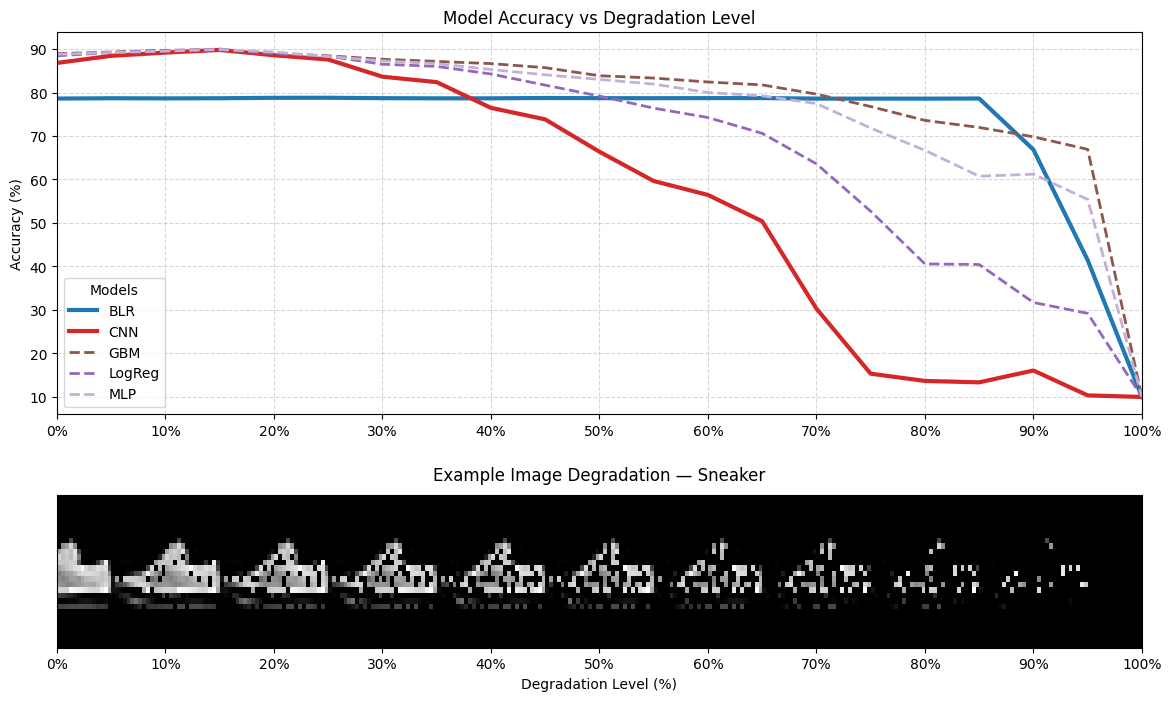

In [ ]:
# degradation levels
dropout_levels = [0,10,20,30,40,50,60,70,80,90,100]

fig = plt.figure(figsize=(14, 8))
gs = fig.add_gridspec(2, 1, height_ratios=[3.5, 1.4], hspace=0.3)

# pixel dropout function
def degrade_image(image, dropout_ratio, hidden_value=0):
    img = image.copy().reshape(-1)
    n_pixels = img.size
    n_hide = int(n_pixels * dropout_ratio)
    np.random.seed(42)
    hide_idx = np.random.choice(n_pixels, n_hide, replace=False)
    img[hide_idx] = hidden_value

    return img.reshape(28, 28)

# Graph for accuracy per degradation level
ax1 = fig.add_subplot(gs[0])
color_map = {
    "CNN": "#d62728",     
    "BLR": "#1f77b4",      
    "LogReg": "#9467bd",   
    "GBM": "#8c564b",
    "MLP": "#c5b0d5"}

for model_name, group in results_df.groupby("Model"):
    ax1.plot(
        group["Degradation"],
        group["Accuracy"],
        label=model_name,
        color=color_map.get(model_name, "gray"),
        linewidth=3 if model_name in ["CNN", "BLR"] else 2,
        linestyle="-" if model_name in ["CNN", "BLR"] else "--")

ax1.set_ylabel("Accuracy (%)")
ax1.set_title("Model Accuracy vs Degradation Level")
ax1.legend(title="Models")
ax1.grid(True, linestyle="--", alpha=0.5)
ax1.set_xlim(0, 100)

# add image degradation below the graph 
ax2 = fig.add_subplot(gs[1], sharex=ax1)
ax2.set_yticks([])
ax2.set_xlabel("Degradation Level (%)")
ax2.set_xticks(dropout_levels)
ax2.set_xticklabels([f"{d}%" for d in dropout_levels])
img_width = 5

for d in dropout_levels:
    degraded = degrade_image(image, d / 100)
    ax2.imshow(
        degraded,
        cmap="gray",
        extent=[d - img_width, d + img_width, 0, 1],
        aspect="auto")

ax2.set_title(f"Example Image Degradation — {label_name}", pad=10)

plt.tight_layout()
plt.savefig("accuracy_with_degradation_images.png", dpi=300)
plt.show()


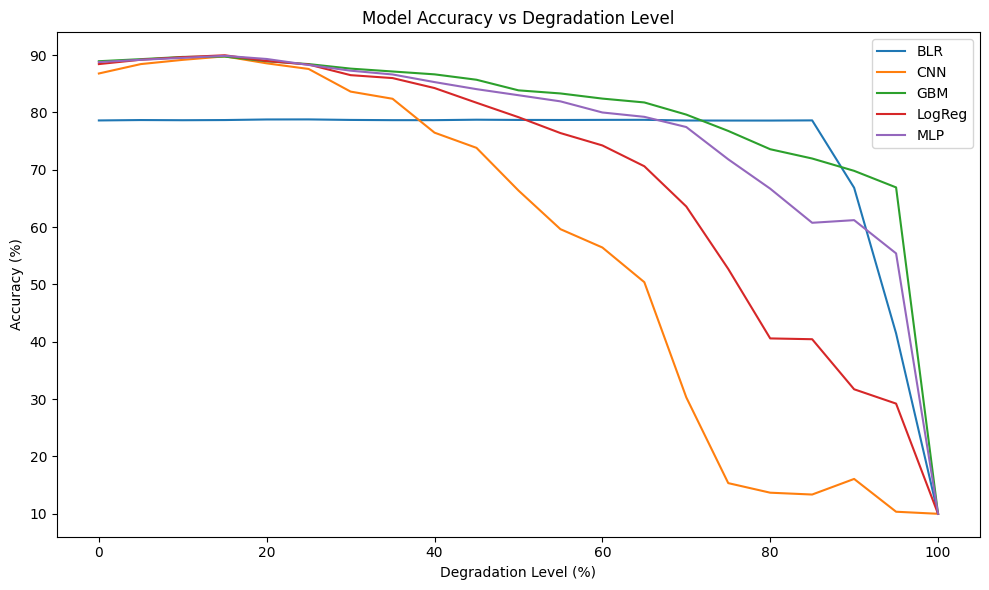

In [ ]:
# old plot 
plt.figure(figsize=(10,6))
for model_name, group in results_df.groupby("Model"):
    plt.plot(group["Degradation"], group["Accuracy"], label=model_name)
plt.xlabel("Degradation Level (%)")
plt.ylabel("Accuracy (%)")
plt.title("Model Accuracy vs Degradation Level")
plt.legend()
plt.tight_layout()
plt.savefig("graphs.png")
plt.show()

In [12]:
results_df

,Degradation,Model,Accuracy,AIC,NLL
0,0,LogReg,88.44,7616.596799,0.347830
1,0,GBM,88.94,6407.077575,0.317154
2,0,MLP,88.79,15556.047213,0.325602
3,5,LogReg,89.20,7191.013100,0.326551
4,5,GBM,89.30,6262.705977,0.309935
...,...,...,...,...,...
100,80,BLR,78.59,13330.344044,0.656517
101,85,BLR,78.62,13263.788124,0.653189
102,90,BLR,66.87,18742.614286,0.927131
103,95,BLR,41.47,29804.839963,1.480242


/var/folders/bq/qnrb3lm539nfznyv5cmr8rph0000gn/T/ipykernel_1103/3217979014.py:58: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


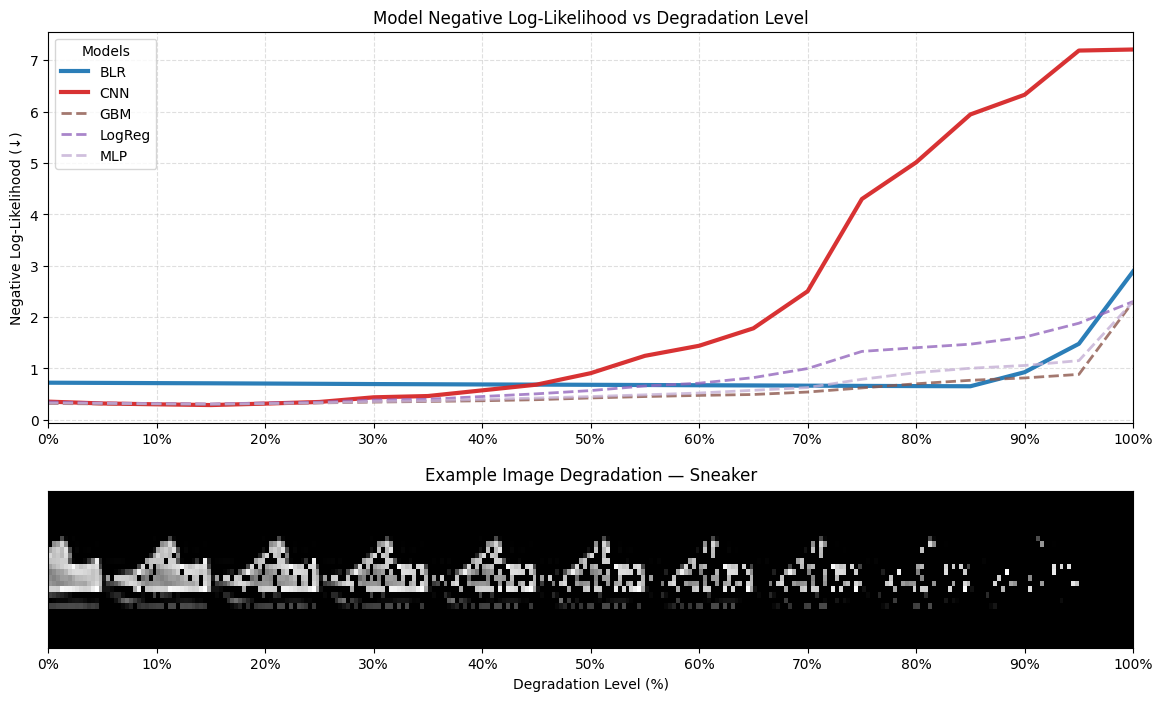

In [ ]:
# degradation levels
dropout_levels = [0,10,20,30,40,50,60,70,80,90,100]

fig = plt.figure(figsize=(14, 8))
gs = fig.add_gridspec(2, 1, height_ratios=[3.5, 1.4], hspace=0.25)

# Graph the NLL per degradation level 
ax1 = fig.add_subplot(gs[0])

color_map = {
    "CNN": "#d62728",     
    "BLR": "#1f77b4",    
    "LogReg": "#9467bd", 
    "GBM": "#8c564b",     
    "MLP": "#c5b0d5"}

for model_name, group in results_df.groupby("Model"):
    ax1.plot(
        group["Degradation"],
        group["NLL"],
        label=model_name,
        color=color_map.get(model_name, "gray"),
        linewidth=3 if model_name in ["CNN", "BLR"] else 2,
        linestyle="-" if model_name in ["CNN", "BLR"] else "--",
        alpha=0.95 if model_name in ["CNN", "BLR"] else 0.8)

ax1.set_ylabel("Negative Log-Likelihood (↓)")
ax1.set_title("Model Negative Log-Likelihood vs Degradation Level")
ax1.legend(title="Models", frameon=True)
ax1.grid(True, linestyle="--", alpha=0.4)
ax1.set_xlim(0, 100)

# add image degradation below the graph 
ax2 = fig.add_subplot(gs[1], sharex=ax1)
ax2.set_yticks([])
ax2.set_xlabel("Degradation Level (%)")
ax2.set_xticks(dropout_levels)
ax2.set_xticklabels([f"{d}%" for d in dropout_levels])
img_width = 5

for d in dropout_levels:
    degraded = degrade_image(image, d / 100)
    ax2.imshow(
        degraded,
        cmap="gray",
        extent=[d - img_width, d + img_width, 0, 1],
        aspect="auto")

ax2.set_title(f"Example Image Degradation — {label_name}", pad=8)

plt.tight_layout()
plt.savefig("nll_with_degradation_images.png", dpi=300)
plt.show()


In [15]:
# get AIC per model  
print("Approximate AIC per model")
aic_mean = results_df.groupby("Model")["AIC"].mean().sort_values()
for model, val in aic_mean.items():
    print(f"{model:>8}: {val:.2f}")

Approximate AIC per model
     GBM: 11327.87
     BLR: 17029.02
  LogReg: 17304.58
     MLP: 21751.36
     CNN: 45871.31


Input to the meta-learner is only the base model probability outputs as features (CNN probabilities (10 classes), BLR probabilities (10 classes)) total 20 features. 

In [ ]:
meta_models = ["LogReg", "GBM", "MLP"]
meta_df = results_df[results_df["Model"].isin(meta_models)]


In [ ]:
# create a summary table by calculating the mean and std 
# of the different metrics aggregated per model
summary_table = (
    meta_df
    .groupby("Model")
    .agg(
        Acc_Mean=("Accuracy", "mean"),
        Acc_Std=("Accuracy", "std"),
        NLL_Mean=("NLL", "mean"),
        NLL_Std=("NLL", "std"),
        AIC_Mean=("AIC", "mean")
    )
    .round(3)
    .reset_index())

summary_table


,Model,Acc_Mean,Acc_Std,NLL_Mean,NLL_Std,AIC_Mean
0,GBM,79.156,17.325,0.563,0.438,11327.874
1,LogReg,68.659,24.467,0.832,0.598,17304.581
2,MLP,76.470,18.542,0.635,0.469,21751.364


# Check SHAP values - experimenting

In [ ]:
# For logistic regression 
level = 0
model = trained_models[(level, "LogReg")]

# Mean absolute coefficient importance
coef_abs = np.abs(model.coef_).mean(axis=0)

feature_names = (
    [f"cnn_p{i}" for i in range(10)] +
    [f"blr_p{i}" for i in range(10)] +
    [f"blr_std{i}" for i in range(10)] +
    ["cnn_entropy", "blr_entropy"])

importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Mean Abs Coefficient": coef_abs
}).sort_values(by="Mean Abs Coefficient", ascending=False)

print(importance_df)

# Aggregate by CNN and BLR
importance_df["Source"] = importance_df["Feature"].apply(
    lambda f: "CNN" if f.startswith("cnn") else "BLR")

print("\nAverage coefficient magnitude by source:")
print(importance_df.groupby("Source")["Mean Abs Coefficient"].mean())

print("coef_abs length:", len(coef_abs))
print("feature_names length:", len(feature_names))

# Global source influence 
source_sum = importance_df.groupby("Source")["Mean Abs Coefficient"].sum()
source_pct = source_sum / source_sum.sum()

print("\nRelative source influence (Logistic Regression):")
print(source_pct)


        Feature  Mean Abs Coefficient
9        cnn_p9              2.342807
7        cnn_p7              2.090981
0        cnn_p0              2.021300
2        cnn_p2              2.001561
3        cnn_p3              1.820534
4        cnn_p4              1.717078
1        cnn_p1              1.649879
5        cnn_p5              1.608448
8        cnn_p8              1.434736
6        cnn_p6              1.294744
30  cnn_entropy              0.957257
10       blr_p0              0.195453
28     blr_std8              0.181859
16       blr_p6              0.140246
11       blr_p1              0.139860
22     blr_std2              0.131725
23     blr_std3              0.115290
14       blr_p4              0.115152
12       blr_p2              0.107201
19       blr_p9              0.105729
26     blr_std6              0.101919
15       blr_p5              0.086663
31  blr_entropy              0.085748
29     blr_std9              0.084267
20     blr_std0              0.079565
27     blr_s

In [20]:
print("Coefficient shape:", getattr(model, "coef_", None))
print("Unique values in coefficient:", np.unique(model.coef_))

Coefficient shape: [[ 6.33106755e+00 -5.52672815e-01  4.79192733e-01 -3.85597521e-02
  -2.78894455e+00 -6.88471864e-01  6.78430764e-01 -1.72095043e+00
   2.96146747e-01 -1.82443647e+00  1.66296458e-01  1.85735719e-01
   3.62624050e-01 -1.06017418e-01 -8.39722595e-02 -8.91816782e-02
  -2.98761948e-02 -6.71732294e-02 -5.41219175e-02 -1.13513687e-01
   1.30325191e-01 -2.54211165e-02 -3.55919496e-02 -1.41776049e-01
  -8.90840246e-02  6.51155383e-02 -4.13681689e-02  1.99095811e-01
   1.56378755e-01  1.51082116e-01  4.18360750e-01  9.28786904e-02]
 [-1.14982857e+00  8.24939695e+00 -2.74946518e+00  2.25373621e+00
  -9.46927909e-01 -7.85276973e-01 -1.78602063e+00 -1.26031732e+00
  -8.94468644e-01 -1.54489133e+00 -1.43119370e-01 -3.00455881e-02
  -3.11605092e-01 -1.46105330e-01 -1.00083213e-02 -1.71132946e-01
  -5.08662237e-02  9.15969978e-02  1.51484027e-01  5.73912607e-03
  -1.42777644e-01 -6.94429208e-02 -1.52348989e-01 -3.53142351e-02
   2.66322956e-02  4.21841915e-03 -1.23911076e-01 -3.474

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
import shap
import numpy as np
import pandas as pd

# Make sure model is trained properly on all classes
level = 0
X, y = load_level(level, split="train")

gbm_model = GradientBoostingClassifier(random_state=42)
gbm_model.fit(X, y)

# Use model-agnostic SHAP
explainer_gbm = shap.Explainer(lambda X: gbm_model.predict_proba(X), X, algorithm="permutation")
shap_values_gbm = explainer_gbm(X)

# Aggregate SHAP values
vals = shap_values_gbm.values
if vals.ndim == 3:
    mean_abs_shap_gbm = np.abs(vals).mean(axis=(0, 2))
else:
    mean_abs_shap_gbm = np.abs(vals).mean(axis=0)

# Build summary DataFrame
feature_names = (
    [f"cnn_p{i}" for i in range(10)] +
    [f"blr_p{i}" for i in range(10)] +
    [f"blr_std{i}" for i in range(10)] +
    ["cnn_entropy", "blr_entropy"])
gbm_shap_df = pd.DataFrame({
    "Feature": feature_names[:len(mean_abs_shap_gbm)],
    "Mean Abs SHAP": mean_abs_shap_gbm
}).sort_values(by="Mean Abs SHAP", ascending=False)
gbm_shap_df["Source"] = gbm_shap_df["Feature"].apply(lambda f: "CNN" if "cnn" in f else "BLR")

print("\nTop GBM SHAP features:")
print(gbm_shap_df.head(10))
print("\nAverage GBM SHAP importance by source:")
print(gbm_shap_df.groupby("Source")["Mean Abs SHAP"].mean())

# Global source influence GBM 
source_sum = gbm_shap_df.groupby("Source")["Mean Abs SHAP"].sum()
source_pct = source_sum / source_sum.sum()

print("\nRelative source influence (GBM, SHAP):")
print(source_pct)




 Loaded level 0 (train)
CNN rows: 54000
BLR rows: 54000


PermutationExplainer explainer: 54001it [3:17:01,  4.57it/s]                             



Top GBM SHAP features:
  Feature  Mean Abs SHAP Source
8  cnn_p8       0.038216    CNN
3  cnn_p3       0.031095    CNN
7  cnn_p7       0.029156    CNN
1  cnn_p1       0.027976    CNN
0  cnn_p0       0.025414    CNN
9  cnn_p9       0.024564    CNN
2  cnn_p2       0.022526    CNN
6  cnn_p6       0.020891    CNN
5  cnn_p5       0.020663    CNN
4  cnn_p4       0.020496    CNN

Average GBM SHAP importance by source:
Source
BLR    0.000323
CNN    0.024076
Name: Mean Abs SHAP, dtype: float64

Relative source influence (GBM, SHAP):
Source
BLR    0.024973
CNN    0.975027
Name: Mean Abs SHAP, dtype: float64


In [ ]:
# calculate entropy contribution 
entropy_shap = gbm_shap_df[
    gbm_shap_df["Feature"].str.contains("entropy")
]["Mean Abs SHAP"].sum()

entropy_pct = entropy_shap / gbm_shap_df["Mean Abs SHAP"].sum()

print(f"\nEntropy features contribute {entropy_pct:.2%} of total SHAP importance.")



Entropy features contribute 1.58% of total SHAP importance.


In [23]:
X, y = load_level(0)
print(pd.DataFrame(X).describe())



 Loaded level 0 (test)
CNN rows: 10000
BLR rows: 10000
                 0             1             2             3             4   \
count  1.000000e+04  1.000000e+04  1.000000e+04  1.000000e+04  1.000000e+04   
mean   1.044374e-01  9.754503e-02  1.322523e-01  1.057967e-01  7.365112e-02   
std    2.654778e-01  2.928076e-01  2.849376e-01  2.799542e-01  2.039344e-01   
min    1.400925e-13  1.235109e-18  3.624799e-17  1.196522e-18  1.072159e-17   
25%    4.956926e-07  2.487944e-10  4.865197e-08  1.918046e-08  3.488144e-08   
50%    3.917452e-04  2.686265e-06  3.199692e-04  1.268524e-05  2.244103e-05   
75%    9.605920e-03  1.266412e-04  5.178744e-02  2.373467e-03  5.587318e-03   
max    9.982873e-01  1.000000e+00  9.998007e-01  9.996076e-01  9.975669e-01   

                 5             6             7             8             9   \
count  1.000000e+04  1.000000e+04  1.000000e+04  1.000000e+04  1.000000e+04   
mean   9.068057e-02  8.597955e-02  9.630271e-02  1.005455e-01  1.128091e-0

# SHAP values (final)

In [ ]:
# Calculate the coefficients - feature influnce of log reg
def logreg_source_influence(model, feature_names):
    # Absolute coefficients
    coef_abs = np.abs(model.coef_) 
    # take the avearege over classes         
    mean_coef = coef_abs.mean(axis=0)      
    # save the results in a dataframe
    df = pd.DataFrame({
        "Feature": feature_names,
        "Importance": mean_coef})

    df["Source"] = df["Feature"].apply(
        lambda f: "CNN" if f.startswith("cnn") else "BLR")

    source_sum = df.groupby("Source")["Importance"].sum()
    source_pct = source_sum / source_sum.sum()

    return source_pct


In [ ]:
logreg_influence = []
# for each degradation level save the probabilities and its standard deviation 
# per model (cnn and blr) for the log reg meta-learner
for level in levels:
    model = trained_models[(level, "LogReg")]

    feature_names = (
        [f"cnn_p{i}" for i in range(10)] +
        [f"blr_p{i}" for i in range(10)] +
        [f"blr_std{i}" for i in range(10)] +
        ["cnn_entropy", "blr_entropy"])

    pct = logreg_source_influence(model, feature_names)

    logreg_influence.append({
        "Degradation": level,
        "CNN": pct.get("CNN", 0.0),
        "BLR": pct.get("BLR", 0.0)})

logreg_df = pd.DataFrame(logreg_influence)


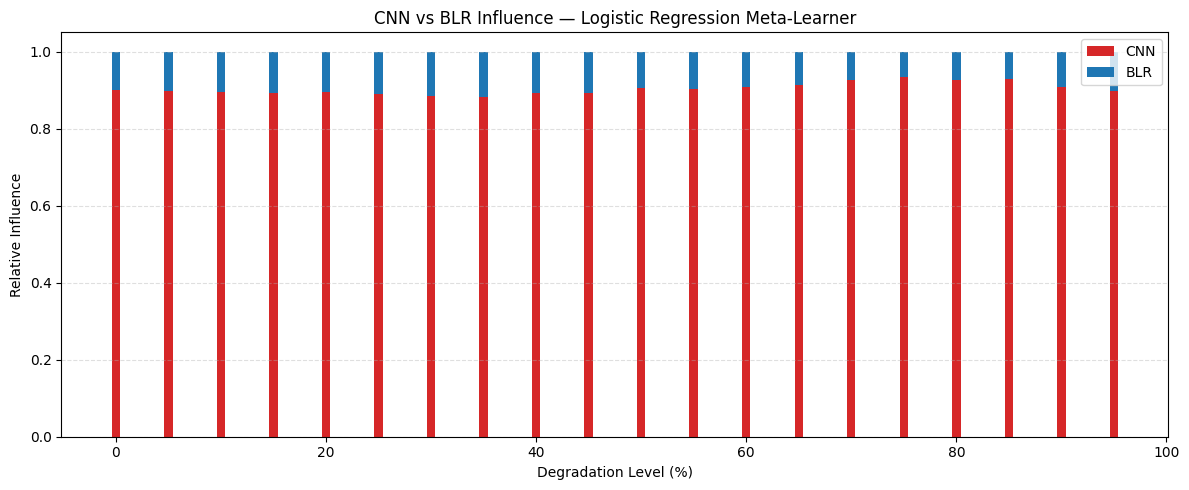

In [ ]:
# create a stacked plot for the relative contribution of the influence of each feature in the decision 
plt.figure(figsize=(12, 5))

plt.bar(
    logreg_df["Degradation"],
    logreg_df["CNN"],
    label="CNN",
    color="#d62728")

plt.bar(
    logreg_df["Degradation"],
    logreg_df["BLR"],
    bottom=logreg_df["CNN"],
    label="BLR",
    color="#1f77b4")

plt.xlabel("Degradation Level (%)")
plt.ylabel("Relative Influence")
plt.title("CNN vs BLR Influence — Logistic Regression Meta-Learner")
plt.legend(frameon=True)
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.savefig("logreg_influence.png", dpi=300)
plt.show()


In [ ]:
# Set the degradation level
# future extension: train on all degradation levels and take the average
level = 0
model = trained_models[(level, "LogReg")]

# Absolute coefficients averaged across classes
coef_abs = np.abs(model.coef_).mean(axis=0)  

feature_names = (
    [f"cnn_p{i}" for i in range(10)] +
    [f"blr_p{i}" for i in range(10)] +
    [f"blr_std{i}" for i in range(10)] +
    ["cnn_entropy", "blr_entropy"])

# seperate cnn and blr
cnn_coef = [
    coef_abs[i] for i, f in enumerate(feature_names)
    if f.startswith("cnn")]

blr_coef = [
    coef_abs[i] for i, f in enumerate(feature_names)
    if f.startswith("blr")]


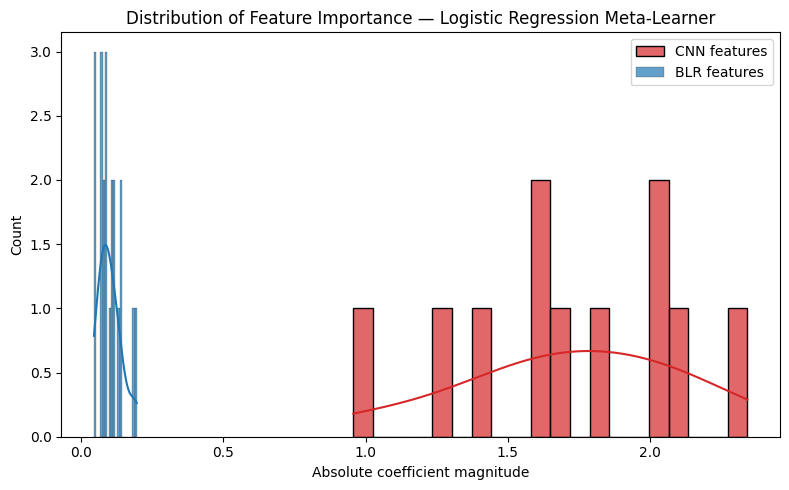

In [ ]:
# Plot a histogram
plt.figure(figsize=(8, 5))

sns.histplot(
    cnn_coef,
    bins=20,
    stat="count",
    color= "#d62728",  
    label="CNN features",
    kde=True,
    alpha=0.7)

sns.histplot(
    blr_coef,
    bins=20,
    stat="count",
    color="#1f77b4",  
    label="BLR features",
    kde=True,
    alpha=0.7)

plt.xlabel("Absolute coefficient magnitude")
plt.ylabel("Count")
plt.title("Distribution of Feature Importance — Logistic Regression Meta-Learner")
plt.legend()
plt.tight_layout()
plt.savefig("logreg_coef_distribution.png", dpi=300)
plt.show()

GBM SHAP Values

In [ ]:
import shap 
# calculate the shap values for the GBM to calculate the feature influence
# use resampling to make it faster and more memory efficient
def gbm_source_influence_light(gbm, X, feature_names, max_samples=200):

    if X.shape[0] > max_samples:
        idx = np.random.choice(X.shape[0], max_samples, replace=False)
        X_sub = X[idx]
    else:
        X_sub = X

    explainer = shap.Explainer(
        lambda x: gbm.predict_proba(x),
        X_sub,
        algorithm="permutation")

    shap_vals = explainer(X_sub).values
    if shap_vals.ndim == 3:
        shap_imp = np.abs(shap_vals).mean(axis=(0, 2))
    else:
        shap_imp = np.abs(shap_vals).mean(axis=0)

    df = pd.DataFrame({
        "Feature": feature_names[:len(shap_imp)],
        "Importance": shap_imp})

    df["Source"] = df["Feature"].apply(
        lambda f: "CNN" if f.startswith("cnn") else "BLR")

    source_sum = df.groupby("Source")["Importance"].sum()
    source_pct = source_sum / source_sum.sum()

    return source_pct

# for saving the results
gbm_influence = []

for level in levels:
    X_train, y_train = load_level(level, split="train")
    # train the gbm
    gbm = GradientBoostingClassifier(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=3,
        random_state=0)
    gbm.fit(X_train, y_train)
    # save the probabilities per model and their standard deviations
    feature_names = (
        [f"cnn_p{i}" for i in range(10)] +
        [f"blr_p{i}" for i in range(10)] +
        [f"blr_std{i}" for i in range(10)] +
        ["cnn_entropy", "blr_entropy"])
    # calculate the shap values 
    source_pct = gbm_source_influence_light(
        gbm, X_train, feature_names, max_samples=200)
    # save the results
    gbm_influence.append({
        "Degradation": level,
        "CNN": source_pct.get("CNN", 0.0),
        "BLR": source_pct.get("BLR", 0.0)})

gbm_df = pd.DataFrame(gbm_influence)



 Loaded level 0 (train)
CNN rows: 54000
BLR rows: 54000


PermutationExplainer explainer: 201it [02:02,  1.51it/s]                         



 Loaded level 5 (train)
CNN rows: 54000
BLR rows: 54000


PermutationExplainer explainer: 201it [02:01,  1.52it/s]                         



 Loaded level 10 (train)
CNN rows: 54000
BLR rows: 54000


PermutationExplainer explainer: 201it [02:01,  1.51it/s]                         



 Loaded level 15 (train)
CNN rows: 54000
BLR rows: 54000


PermutationExplainer explainer: 201it [02:02,  1.50it/s]                         



 Loaded level 20 (train)
CNN rows: 54000
BLR rows: 54000


PermutationExplainer explainer: 201it [2:18:51, 44.32s/it]                            



 Loaded level 25 (train)
CNN rows: 54000
BLR rows: 54000


PermutationExplainer explainer: 201it [01:59,  1.54it/s]                         



 Loaded level 30 (train)
CNN rows: 54000
BLR rows: 54000


PermutationExplainer explainer: 201it [02:04,  1.48it/s]                         



 Loaded level 35 (train)
CNN rows: 54000
BLR rows: 54000


PermutationExplainer explainer: 201it [02:03,  1.49it/s]                         



 Loaded level 40 (train)
CNN rows: 54000
BLR rows: 54000


PermutationExplainer explainer: 201it [02:08,  1.44it/s]                         



 Loaded level 45 (train)
CNN rows: 54000
BLR rows: 54000


PermutationExplainer explainer: 201it [02:09,  1.43it/s]                         



 Loaded level 50 (train)
CNN rows: 54000
BLR rows: 54000


PermutationExplainer explainer: 201it [02:12,  1.40it/s]                         



 Loaded level 55 (train)
CNN rows: 54000
BLR rows: 54000


PermutationExplainer explainer: 201it [02:11,  1.41it/s]                         



 Loaded level 60 (train)
CNN rows: 54000
BLR rows: 54000


PermutationExplainer explainer: 201it [02:13,  1.38it/s]                         



 Loaded level 65 (train)
CNN rows: 54000
BLR rows: 54000


PermutationExplainer explainer: 201it [02:18,  1.34it/s]                         



 Loaded level 70 (train)
CNN rows: 54000
BLR rows: 54000


PermutationExplainer explainer: 201it [02:13,  1.38it/s]                         



 Loaded level 75 (train)
CNN rows: 54000
BLR rows: 54000


PermutationExplainer explainer: 201it [02:18,  1.34it/s]                         



 Loaded level 80 (train)
CNN rows: 54000
BLR rows: 54000


PermutationExplainer explainer: 201it [02:20,  1.33it/s]                         



 Loaded level 85 (train)
CNN rows: 54000
BLR rows: 54000


PermutationExplainer explainer: 201it [02:24,  1.29it/s]                         



 Loaded level 90 (train)
CNN rows: 54000
BLR rows: 54000


PermutationExplainer explainer: 201it [02:24,  1.30it/s]                         



 Loaded level 95 (train)
CNN rows: 54000
BLR rows: 54000


PermutationExplainer explainer: 201it [02:25,  1.28it/s]                         



 Loaded level 100 (train)
CNN rows: 54000
BLR rows: 54000


In [ ]:
# Use subsampled SHAP 
X_sub = X[np.random.choice(X.shape[0], 200, replace=False)]

explainer = shap.Explainer(
    lambda x: gbm_model.predict_proba(x),
    X_sub,
    algorithm="permutation")

shap_vals = explainer(X_sub).values

if shap_vals.ndim == 3:
    shap_vals = np.abs(shap_vals).mean(axis=2) 
else:
    shap_vals = np.abs(shap_vals)

# seperate the cnn and blr
cnn_idx = [i for i, f in enumerate(feature_names) if f.startswith("cnn")]
blr_idx = [i for i, f in enumerate(feature_names) if f.startswith("blr")]

cnn_shap = shap_vals[:, cnn_idx].flatten()
blr_shap = shap_vals[:, blr_idx].flatten()


PermutationExplainer explainer: 201it [00:44,  3.49it/s]                         


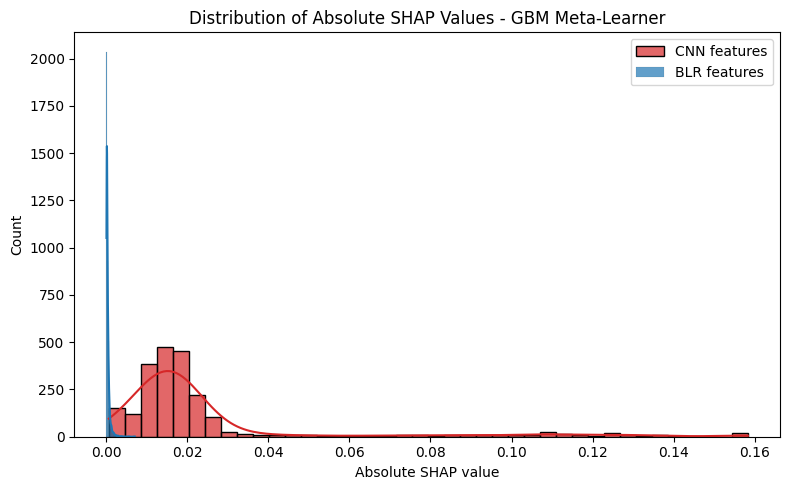

In [ ]:
# Plot the histogram
plt.figure(figsize=(8, 5))

sns.histplot(
    cnn_shap,
    bins=40,
    stat="count",
    color="#d62728",
    label="CNN features",
    kde=True,
    alpha=0.7)

sns.histplot(
    blr_shap,
    bins=40,
    stat="count",
    color="#1f77b4",
    label="BLR features",
    kde=True,
    alpha=0.7)

plt.xlabel("Absolute SHAP value")
plt.ylabel("Count")
plt.title("Distribution of Absolute SHAP Values - GBM Meta-Learner")
plt.legend()
plt.tight_layout()
plt.savefig("shap_distribution.png", dpi=300)
plt.show()


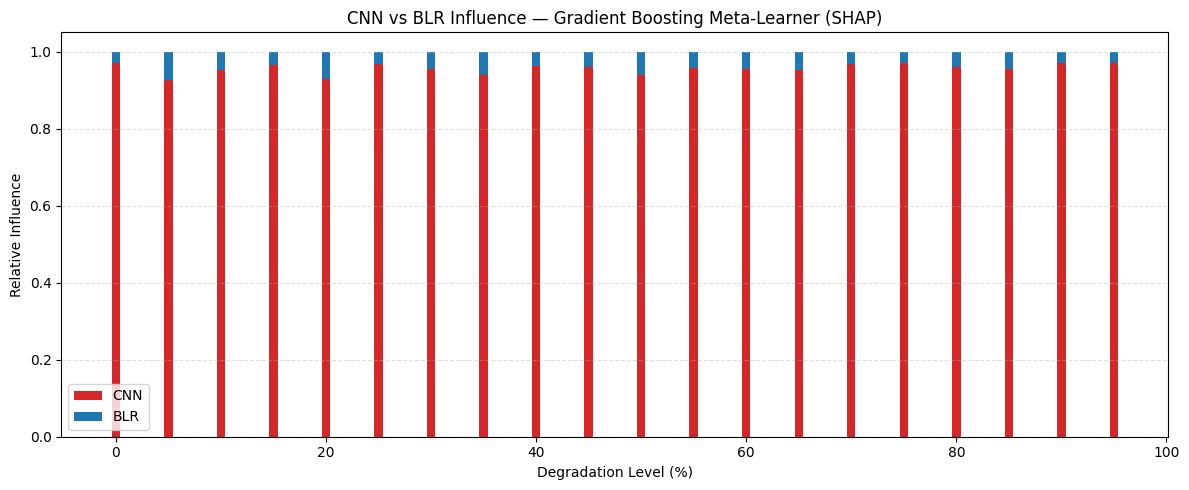

In [ ]:
# Plot the stacked barplot
plt.figure(figsize=(12, 5))

plt.bar(
    gbm_df["Degradation"],
    gbm_df["CNN"],
    label="CNN",
    color="#d62728")

plt.bar(
    gbm_df["Degradation"],
    gbm_df["BLR"],
    bottom=gbm_df["CNN"],
    label="BLR",
    color="#1f77b4")

plt.xlabel("Degradation Level (%)")
plt.ylabel("Relative Influence")
plt.title("CNN vs BLR Influence — Gradient Boosting Meta-Learner (SHAP)")
plt.legend(frameon=True)
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.savefig("gbm_influence.png", dpi=300)
plt.show()


For Logistic Regression, model influence is derived directly from the absolute coefficient magnitudes, which provide an exact and interpretable measure of feature contribution. For Gradient Boosting, where no linear coefficients exist, we estimate influence using SHAP values aggregated across samples and classes. In both cases, feature contributions are grouped by model source (CNN or BLR) and normalised to obtain relative influence percentages.